In [1]:
#! pip install Geopandas
#!pip install --use-deprecated=legacy-resolver pycaret[full]
#!pip install pycaret[full]

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os.path


import seaborn as sns
from scipy import stats


# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.pyplot import *
import imageio
from skimage.io import imread

from tqdm import tqdm

import cv2   #For image processing

import tensorflow as tf
#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


import sklearn
from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of data
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv, rgba2rgb
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage import io, color

from pycaret.datasets import get_data
from pycaret.regression import *

In [3]:
#set directory for csv files
dir_name = r'C:\Users\vasan\OneDrive\EmissionsDatathon\Zeroing Methane Emissions - Dataset'
filename_suffix = 'xls'

In [4]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("datamodel.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,source_id,source_lat,source_lon,source_type_y,ipcc,number_overflights,source_persistence,confidence_in_persistence,qsource,sigma_qsource,Filepath,Name,candidate_id,plume_lat,plume_lon,date,qplume,sigma_qplume,Uncern
0,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-2_r4578_c217-plume.png,ang20190922t192642-2,32.212063,-103.697076,2019-09-22,2579.528100,902.732655,133.151448
1,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190923t163307-G_r4113_c198-plume.png,ang20190923t163307-G,32.212117,-103.697086,2019-09-23,934.430300,276.716131,736.942230
2,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190926t223557-D_r4139_c225-plume.png,ang20190926t223557-D,32.212162,-103.696830,2019-09-26,443.098484,152.257940,110.191596
3,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20191006t150453-6_r4168_c237-plume.png,ang20191006t150453-6,32.212327,-103.697526,2019-10-06,1032.395030,606.623335,244.327697
4,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20191007t182352-2_r4062_c150-plume.png,ang20191007t182352-2,32.212253,-103.697253,2019-10-07,826.823256,226.851094,135.781536


In [5]:
df.describe()

,source_lat,source_lon,number_overflights,source_persistence,qsource,sigma_qsource,plume_lat,plume_lon,qplume,sigma_qplume,Uncern
count,6062.000000,6062.000000,6062.000000,6062.000000,6062.000000,6062.000000,6062.000000,6062.000000,6062.000000,6062.000000,5990.000000
mean,33.062778,-104.179228,5.185087,0.551059,305.836566,100.361834,33.062778,-104.179227,559.042147,183.240800,71.067197
std,2.430492,7.096847,3.336843,0.315326,467.552992,155.206428,2.430492,7.096847,797.892685,269.671393,166.995204
min,25.857711,-122.412006,1.000000,0.071429,2.697304,0.625286,25.857300,-122.412006,8.091911,4.246207,0.450500
25%,31.822890,-104.097143,3.000000,0.285714,74.051119,24.749421,31.822863,-104.097101,166.331086,54.947155,22.537497
50%,32.066110,-103.737620,4.000000,0.500000,159.948436,54.200015,32.066123,-103.737790,307.209799,103.020765,36.563889
75%,32.558432,-103.032393,9.000000,0.857143,325.974110,110.156066,32.558554,-103.032501,615.901103,202.875586,59.994311
max,42.281528,-75.581762,14.000000,1.000000,5316.639288,2168.145498,42.281596,-75.581762,16811.280200,8519.241420,5363.490487


In [6]:
df.shape

(6062, 19)

In [7]:
print("Upper limit",df['qplume'].mean() + 3*df['qplume'].std())
print("Lower limit",df['qplume'].mean() - 3*df['qplume'].std())

Upper limit 2952.720203508437
Lower limit -1834.63590894246


In [8]:
df = df.loc[df['qplume'] < 2953]

In [9]:
df.shape

(5943, 19)

In [10]:
def image_processing(fil):
    # Open image and import it as a numpy array
    im2 = imread(fil)
    im2_rgb = color.rgba2rgb(im2)
    im2_hsv = rgb2hsv(im2_rgb)
    
    mask = im2_hsv[:,:,1] > 0.4
    
    red = im2[:,:,0]*mask
    green = im2[:,:,1]*mask
    blue = im2[:,:,2]*mask
    
    flat_red = red.flatten()
    flat_green = green.flatten()
    flat_blue = blue.flatten()
    
    nonzero_red = flat_red[flat_red != 0]
    nonzero_green = flat_green[flat_green != 0]
    nonzero_blue = flat_blue[flat_blue != 0]
    
    meanr = np.mean(nonzero_red)
    meang = np.mean(nonzero_green)
    meanb = np.mean(nonzero_blue)
    
    filename = fil.split("/")[-1]
    
    return (meanr, meang, meanb)

In [11]:
meanr_list = []
meang_list = []
meanb_list = []
name_list = []
qplume = []

In [12]:
for file in tqdm(df['Filepath'].tolist()[:]):
    meanr, meang, meanb = image_processing(file)
    meanr_list.append(meanr)
    meang_list.append(meang)
    meanb_list.append(meanb)
    name_list.append(os.path.basename(file))  # add filename to list

100%|██████████| 5943/5943 [02:15<00:00, 43.77it/s]


In [13]:
dfeat = pd.DataFrame({'Red': meanr_list, 'Green': meang_list, 'Blue': meanb_list, 'Name': name_list})

In [14]:
dfeat.head()

,Red,Green,Blue,Name
0,181.358816,47.365528,58.732138,ang20190922t192642-2_r4578_c217-plume.png
1,163.016873,116.526079,86.684041,ang20190923t163307-G_r4113_c198-plume.png
2,148.860910,65.633528,55.371571,ang20190926t223557-D_r4139_c225-plume.png
3,195.260858,106.511460,97.770766,ang20191006t150453-6_r4168_c237-plume.png
4,175.007143,133.739831,96.091491,ang20191007t182352-2_r4062_c150-plume.png


In [15]:
dfeat3 = pd.merge(dfeat, df[['qplume', 'Name']], on='Name')

In [16]:
dfeat3.head()

,Red,Green,Blue,Name,qplume
0,181.358816,47.365528,58.732138,ang20190922t192642-2_r4578_c217-plume.png,2579.528100
1,163.016873,116.526079,86.684041,ang20190923t163307-G_r4113_c198-plume.png,934.430300
2,148.860910,65.633528,55.371571,ang20190926t223557-D_r4139_c225-plume.png,443.098484
3,195.260858,106.511460,97.770766,ang20191006t150453-6_r4168_c237-plume.png,1032.395030
4,175.007143,133.739831,96.091491,ang20191007t182352-2_r4062_c150-plume.png,826.823256


In [17]:
dfeat3.isna().sum()

Red         2
Green      10
Blue      365
Name        0
qplume      0
dtype: int64

In [42]:
zero_mask = dfeat3.eq(0)

In [44]:
zero_mask.sum().sum()

0

In [18]:
dfeat3 = dfeat3.dropna()

In [19]:
dfeat3.shape

(5578, 5)

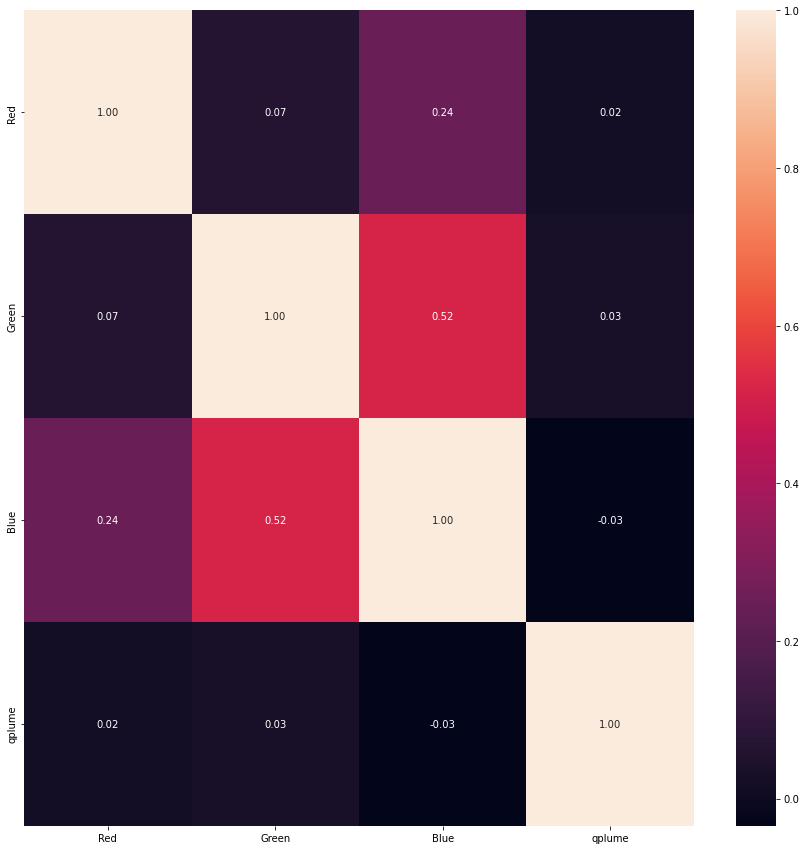

In [20]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(dfeat3.corr(), annot=True, fmt=".2f")

In [21]:
dfeat3.shape

(5578, 5)

In [22]:
dfeat3 = dfeat3.drop('Name', axis=1)

In [23]:
#dfeat3.to_excel("dfeat3all.xlsx")  

In [24]:
# Creates a mask where values that are true go into the training/test set
# Note that I done it so that the random number is predictable

msk = np.random.seed(0)
msk = np.random.rand(len(dfeat3))<0.8

dftrain = dfeat3[msk]
dftest = dfeat3[~msk]

print(dftrain.shape)
print(dftest.shape)

(4475, 4)
(1103, 4)


In [25]:
dftrain

,Red,Green,Blue,qplume
0,181.358816,47.365528,58.732138,2579.528100
1,163.016873,116.526079,86.684041,934.430300
2,148.860910,65.633528,55.371571,443.098484
3,195.260858,106.511460,97.770766,1032.395030
4,175.007143,133.739831,96.091491,826.823256
...,...,...,...,...
5936,198.546502,8.646487,108.565217,488.787135
5938,181.612364,58.960765,98.103226,1553.155303
5939,185.030525,76.448276,95.907407,640.037946
5940,84.151522,45.405511,48.114750,438.412306


In [26]:
target_columns = [
    "qplume"
]

y_train = dftrain[target_columns]
X_train = dftrain.drop(columns=target_columns)

In [27]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [28]:
y_predtrain = model_lr.predict(X_train)

In [29]:
print('Coefficients:', model_lr.coef_)
print('Intercept:', model_lr.intercept_)

Coefficients: [[ 0.4469367   0.67530318 -1.21224657]]
Intercept: [449.46463127]


In [30]:
# Calculate the mean squared error
mse = mean_squared_error(y_train, y_predtrain)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

r2 = r2_score(y_train, y_predtrain)
print("Test R^2 Score: {:.5f}".format(r2))

Root Mean Squared Error: 507.2425762508364
Test R^2 Score: 0.00479


In [31]:
y_test = dftest[target_columns]
X_test= dftest.drop(columns=target_columns)

In [32]:
y_predtest = model_lr.predict(X_test)

In [33]:
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_predtest)

# Calculate the root mean squared error
rmset = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

r2t = r2_score(y_test, y_predtest)
print("Test R^2 Score: {:.5f}".format(r2))

Root Mean Squared Error: 507.2425762508364
Test R^2 Score: 0.00479


In [34]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
dfsub = pd.read_excel("dfsub.xlsx", thousands=',', skiprows = skiprows)
dfsub = dfsub.loc[:, ~dfsub.columns.str.contains('^Unnamed')] 
dfsub.head()

,Red,Green,Blue
0,94.390956,109.400125,179.221933
1,92.910174,111.842154,199.957061
2,110.781377,118.080972,188.804082
3,97.612245,97.132653,213.602041
4,94.207557,99.177906,211.434359


In [35]:
dfsub.shape

(20, 3)

In [36]:
y_predsub = model_lr.predict(dfsub)

In [37]:
y_predsub

array([[348.26849128],
       [324.1196979 ],
       [349.84024886],
       [299.74677346],
       [302.23402374],
       [296.80037512],
       [322.61769413],
       [297.30517506],
       [345.34877528],
       [512.23386457],
       [380.44952674],
       [382.79850389],
       [428.40338521],
       [297.89875743],
       [330.26731941],
       [422.61242875],
       [396.06261415],
       [442.76341413],
       [468.05727132],
       [454.55004304]])

In [39]:
np.savetxt('17b.csv', y_predsub, delimiter=',')